In [1]:
"""
Experiment with getting and viewing MNIST
Uses TorchVision.
Examples taken from tutorial:
  https://nextjournal.com/gkoehler/pytorch-mnist
  
"""

import torch
import torchvision
import matplotlib.pyplot as plt

# Set random seed so we can repeat
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Set up object to load the MNIST data
batch_size_train = 64

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)



torch.Size([64, 1, 28, 28])


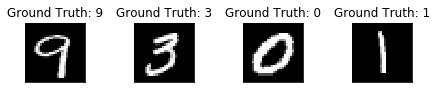

In [2]:

# Look at some examples
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)          

fig = plt.figure()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn

#import torch.nn.functional as F
import torch.optim as optim

data_dir = '/files/'

In [4]:
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [5]:
# ======== Set up the encoder class ============

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer (Doesn't exist in early versions)
#        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, fc_dim),
            nn.ReLU(True),
            nn.Linear(fc_dim, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = x.view(-1, 32*3*3)   # View image as a vector
        x = self.encoder_lin(x)
        return x
    

In [6]:
# ======== Set up the decoder class ============

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, fc_dim),
            nn.ReLU(True),
            nn.Linear(fc_dim, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x=x.view(-1,32,3,3) # Reshape vector into an image
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    
    

In [7]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
latent_dim=2

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=latent_dim,fc_dim=64)
decoder = Decoder(encoded_space_dim=latent_dim,fc_dim=64)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

device = torch.device("cpu")

In [8]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if (len(train_loss) % 20==0):
            print('\t Partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [9]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

	 Partial train loss (single batch): 0.277320
	 Partial train loss (single batch): 0.247514
	 Partial train loss (single batch): 0.223114
	 Partial train loss (single batch): 0.201494
	 Partial train loss (single batch): 0.179791
	 Partial train loss (single batch): 0.160633
	 Partial train loss (single batch): 0.143223
	 Partial train loss (single batch): 0.127155
	 Partial train loss (single batch): 0.113571
	 Partial train loss (single batch): 0.102896

 EPOCH 1/10 	 train loss 0.17305973172187805 	 val loss 0.09800013899803162


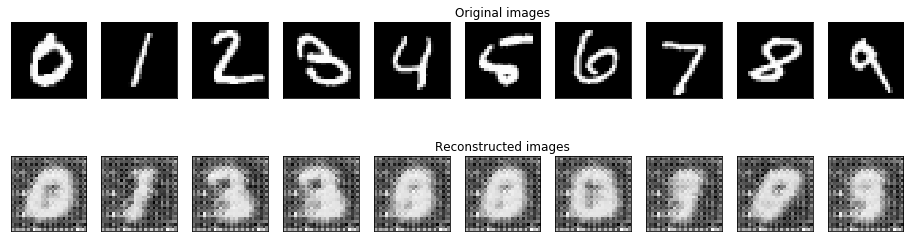

	 Partial train loss (single batch): 0.098147
	 Partial train loss (single batch): 0.088446
	 Partial train loss (single batch): 0.083303
	 Partial train loss (single batch): 0.075403
	 Partial train loss (single batch): 0.072500
	 Partial train loss (single batch): 0.067169
	 Partial train loss (single batch): 0.064769
	 Partial train loss (single batch): 0.063486
	 Partial train loss (single batch): 0.061573
	 Partial train loss (single batch): 0.060703

 EPOCH 2/10 	 train loss 0.07185649871826172 	 val loss 0.058651041239500046


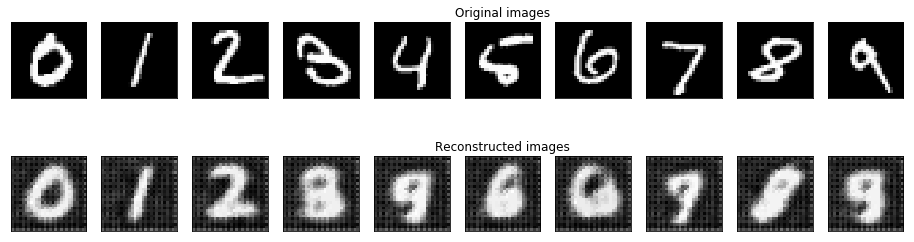

	 Partial train loss (single batch): 0.058081
	 Partial train loss (single batch): 0.054858
	 Partial train loss (single batch): 0.057496
	 Partial train loss (single batch): 0.054146
	 Partial train loss (single batch): 0.055741
	 Partial train loss (single batch): 0.053179
	 Partial train loss (single batch): 0.053355
	 Partial train loss (single batch): 0.054304
	 Partial train loss (single batch): 0.053444
	 Partial train loss (single batch): 0.053573

 EPOCH 3/10 	 train loss 0.054100219160318375 	 val loss 0.051693037152290344


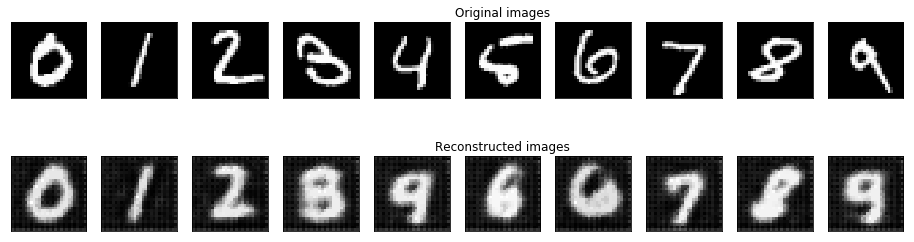

	 Partial train loss (single batch): 0.051461
	 Partial train loss (single batch): 0.049275
	 Partial train loss (single batch): 0.052202
	 Partial train loss (single batch): 0.049610
	 Partial train loss (single batch): 0.051406
	 Partial train loss (single batch): 0.049537
	 Partial train loss (single batch): 0.050435
	 Partial train loss (single batch): 0.051585
	 Partial train loss (single batch): 0.051038
	 Partial train loss (single batch): 0.051043

 EPOCH 4/10 	 train loss 0.05020444840192795 	 val loss 0.04960228130221367


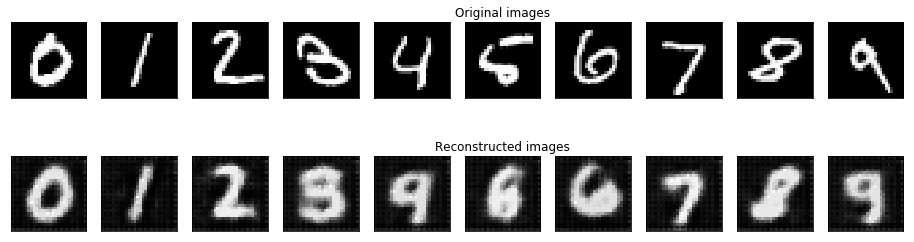

	 Partial train loss (single batch): 0.049370
	 Partial train loss (single batch): 0.047233
	 Partial train loss (single batch): 0.050019
	 Partial train loss (single batch): 0.048279
	 Partial train loss (single batch): 0.049771
	 Partial train loss (single batch): 0.047868
	 Partial train loss (single batch): 0.049279
	 Partial train loss (single batch): 0.050168
	 Partial train loss (single batch): 0.049679
	 Partial train loss (single batch): 0.049666

 EPOCH 5/10 	 train loss 0.04849213734269142 	 val loss 0.04813474416732788


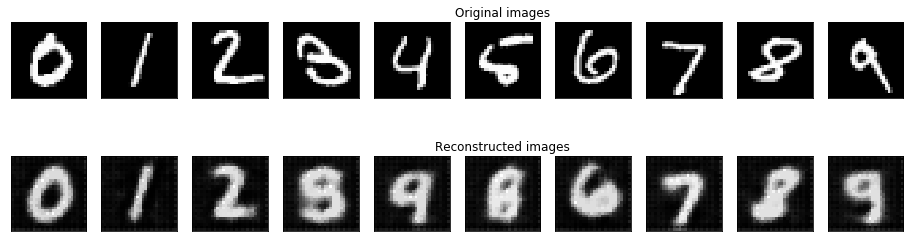

	 Partial train loss (single batch): 0.047687
	 Partial train loss (single batch): 0.045971
	 Partial train loss (single batch): 0.048923
	 Partial train loss (single batch): 0.047197
	 Partial train loss (single batch): 0.048502
	 Partial train loss (single batch): 0.046885
	 Partial train loss (single batch): 0.047826
	 Partial train loss (single batch): 0.049348
	 Partial train loss (single batch): 0.048488
	 Partial train loss (single batch): 0.048541

 EPOCH 6/10 	 train loss 0.04737681522965431 	 val loss 0.047109346836805344


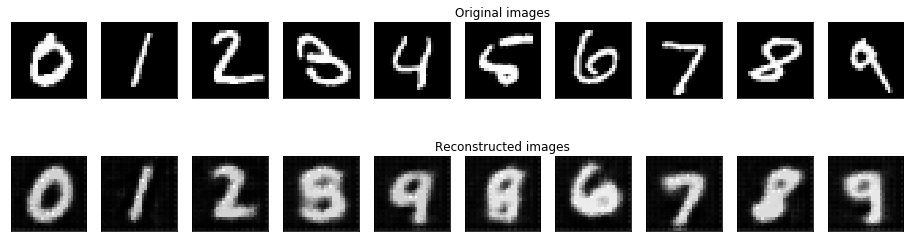

	 Partial train loss (single batch): 0.046494
	 Partial train loss (single batch): 0.045271
	 Partial train loss (single batch): 0.047780
	 Partial train loss (single batch): 0.046437
	 Partial train loss (single batch): 0.047410
	 Partial train loss (single batch): 0.045999
	 Partial train loss (single batch): 0.047041
	 Partial train loss (single batch): 0.048751
	 Partial train loss (single batch): 0.047762
	 Partial train loss (single batch): 0.047662

 EPOCH 7/10 	 train loss 0.04650264233350754 	 val loss 0.0463782474398613


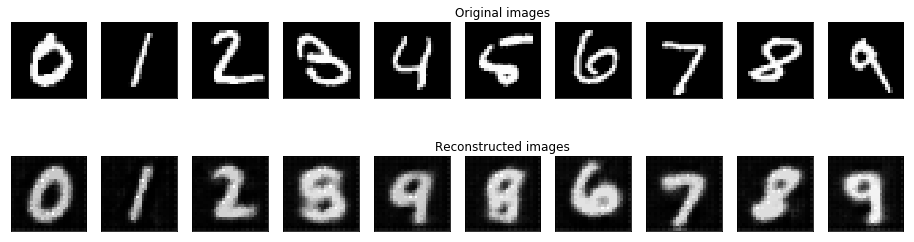

	 Partial train loss (single batch): 0.045828
	 Partial train loss (single batch): 0.044425
	 Partial train loss (single batch): 0.047198
	 Partial train loss (single batch): 0.045593
	 Partial train loss (single batch): 0.046587
	 Partial train loss (single batch): 0.045383
	 Partial train loss (single batch): 0.046279
	 Partial train loss (single batch): 0.048043
	 Partial train loss (single batch): 0.046707
	 Partial train loss (single batch): 0.047381

 EPOCH 8/10 	 train loss 0.045736540108919144 	 val loss 0.04560834914445877


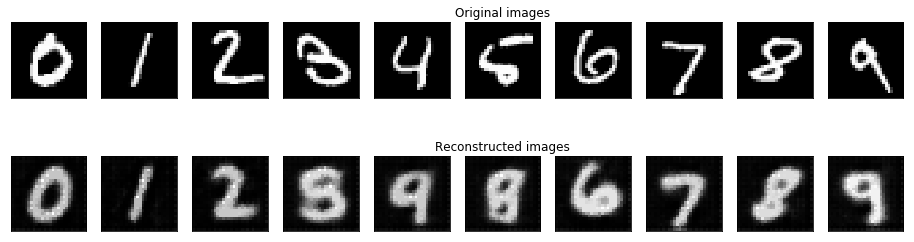

	 Partial train loss (single batch): 0.044888
	 Partial train loss (single batch): 0.043728
	 Partial train loss (single batch): 0.046450
	 Partial train loss (single batch): 0.044902
	 Partial train loss (single batch): 0.045801
	 Partial train loss (single batch): 0.044664
	 Partial train loss (single batch): 0.045456
	 Partial train loss (single batch): 0.047456
	 Partial train loss (single batch): 0.046065
	 Partial train loss (single batch): 0.046466

 EPOCH 9/10 	 train loss 0.04500972852110863 	 val loss 0.04490983486175537


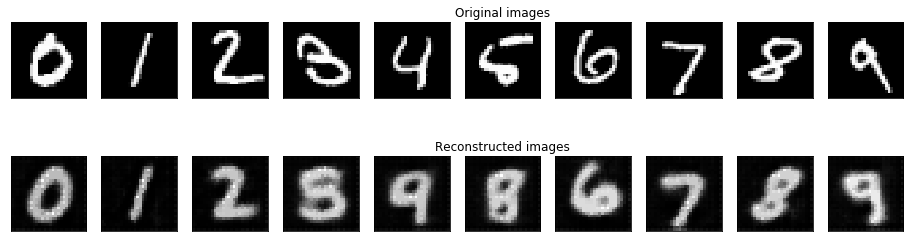

	 Partial train loss (single batch): 0.043961
	 Partial train loss (single batch): 0.043373
	 Partial train loss (single batch): 0.045717
	 Partial train loss (single batch): 0.044104
	 Partial train loss (single batch): 0.045021
	 Partial train loss (single batch): 0.043757
	 Partial train loss (single batch): 0.044888
	 Partial train loss (single batch): 0.046394
	 Partial train loss (single batch): 0.045369
	 Partial train loss (single batch): 0.046265

 EPOCH 10/10 	 train loss 0.04435299336910248 	 val loss 0.04427191987633705


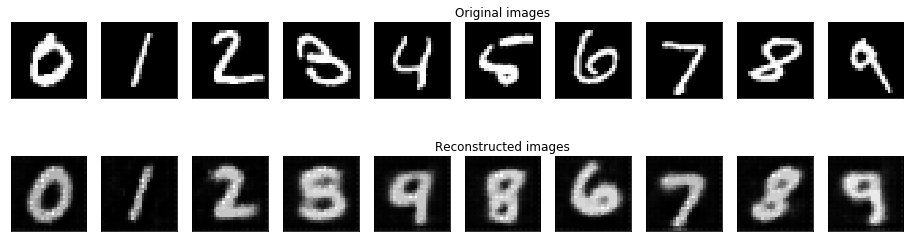

In [10]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)
   